**Jiahao (Derek) Ye**

Spring 2020

CS 251: Data Analysis and Visualization

Project 5: Clustering

In [389]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import multivariate_normal

import kmeans
import em

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 5) EM Algorithm

### 5a) Implement multivariate Gaussian (`gaussian`)

**LA section:** Implement from scratch (i.e. using common numpy math functions and `np.linalg.det` and `np.linalg.inv`)

**Non-LA section:** Make a wrapper for Scipy stats multivariate normal pdf function.

In [390]:
# Test 1: 2D data
np.random.seed(0)
test_xy = np.random.randn(5,2)
test_mu = np.random.uniform(size=(2,))
test_sigma = np.array([[2, 1.5], [1.5, 2]])

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_xy, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.06237 0.02907 0.00424 0.08301 0.08269]')

Your Gaussian PDF evaluated that the test points:
[0.06237 0.02907 0.00424 0.08301 0.08269]
It should be
[0.06237 0.02907 0.00424 0.08301 0.08269]


In [391]:
# Test 2: 4-dimensional data
np.random.seed(0)
test_10 = np.random.randn(5,4)
test_mu = np.random.uniform(size=(4,))
test_sigma = np.random.uniform(size=(4,4))
test_sigma = test_sigma.T @ test_sigma

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_10, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.      0.      0.      0.13288 0.     ]')

Your Gaussian PDF evaluated that the test points:
[0.      0.      0.      0.13288 0.     ]
It should be
[0.      0.      0.      0.13288 0.     ]


### 5b) Implement EM algorithm

Implement each of the following core methods in `em.py`. 

- `initialize`: Initialize cluster means, variance, and the probability that data samples belong to each of the clusters.
- `e_step`: Expectation step of EM algorithm. Compute probability each datapoint belongs to each cluster.
- `m_step`: Maximization step of EM algorithm. Compute each Gaussian cluster's mean and covariance matrix based on data assigned to each cluster.
- `log_likelihood`: Used in EM to monitor clustering progress and detect convergence. Log of sum of probabilities of all data points assigned to all clusters.
- `cluster`: Method that runs EM algorithm.

**E-Step equations:**

Compute the *responsibilities* ($w_{ci}$): the probability that data sample $i$ belongs to cluster $c$.

It can be computed in two stages: Determine $\hat{w}_{ci}$ then ${w}_{ci}$. $$\hat{w}_{ci} = \pi_c \times G\left (\mathbf{data}, \vec{\mu}_c, \mathbf{\Sigma_c}  \right )$$ Above, $\pi_c$ is the proportion of data samples that are associated with cluster $c$ (more on this below), $G(\cdot,\cdot,\cdot)$ is a multivariate Gaussian (representing cluster $c$), $\vec{\mu}_c$ is the mean (*centroid*) of that Gaussian cluster $c$, and $\mathbf{\Sigma_c}$ is the covariance matrix for cluster $c$.$${w}_{ci} = \frac{\hat{w}_{ci}}{\sum_{d=1}^{k}\hat{w}_{di}}$$


**M-Step equations:**

The job of the M-step is to compute the Gaussian cluster centroids ($\vec{\mu}_c$), Gaussian cluster covariance matrices ($\mathbf{\Sigma}_c$), and proportion of data samples that are associated each cluster ($\pi_c$).

$\pi_c$ is the average responsibility of all data samples with respect to each cluster $c$: $$\pi_c = \frac{1}{N}\sum_{j=1}^N w_{cj}$$
Note that above $N$ is the number of data samples. $$\vec{\mu}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \times \vec{\text{data}}_j $$
Above $R_c$ is defined as the sum of the responsibilities of all data samples belonging to one cluster: $R_c = \sum_{j=1}^N {w}_{cj}$.

Finally, the covariance of each cluster $\mathbf{\Sigma}_c$ is computed as: $$\mathbf{\Sigma}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \left ( \vec{\text{data}}_j - \vec{\mu}_c \right )^T \left ( \vec{\text{data}}_j - \vec{\mu}_c \right ) $$
where above $T$ indicates transpose.

**Log-likelihood:**

$$ll = \sum_{i=1}^N Log \left [\sum_{c=1}^k \pi_c f_c \left ( \vec{x}_i; \vec{\mu}_c, \Sigma_c \right ) \right]$$

where $f_c(\cdot)$ is the Gaussian distribution.

#### Test `e_step` (and `initialize`)

In [392]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initalize(test_k)
print(f'Your centroid shapes are {em_test.centroids.shape} and should be (2, 2)\n')

test_init_centroids = np.array([[1.76405, 0.40016], [0.97874, 2.24089]])
em_test.centroids = test_init_centroids
test_probs = em_test.e_step()
print(f'After 1 E step, your test responsibilities are:\n{test_probs}\nand should be:\n[[0.88106 0.11894 0.99024 0.91517 0.62642]\n\
 [0.11894 0.88106 0.00976 0.08483 0.37358]]')

Your centroid shapes are (2, 2) and should be (2, 2)

After 1 E step, your test responsibilities are:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]
and should be:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]


#### Test `m_step`

In [393]:
test_m, test_s, test_pi = em_test.m_step()

print(f'After 1 EM iteration, your means are\n{test_m}\n')
print(f'After 1 EM iteration, your covariance matrix is\n{test_s}\n')
print(f'After 1 EM iteration, your pi array is\n{test_pi}\n')

After 1 EM iteration, your means are
[[ 1.22452 -0.06511]
 [ 0.77131  1.46643]]

After 1 EM iteration, your covariance matrix is
[[[ 0.52278 -0.22681]
  [-0.22681  0.50843]]

 [[ 0.3101   0.21107]
  [ 0.21107  0.92664]]]

After 1 EM iteration, your pi array is
[0.70637 0.29363]



The above test should output:

    After 1 EM iteration, your means are
    [[ 1.22452 -0.06511]
     [ 0.77131  1.46643]]

    After 1 EM iteration, your covariance matrix is
    [[[ 0.52278 -0.22681]
      [-0.22681  0.50843]]

     [[ 0.3101   0.21107]
      [ 0.21107  0.92664]]]

    After 1 EM iteration, your pi array is
    [0.70637 0.29363]

#### Test `log_likelihood`

In [395]:
print(f'After running 1 EM iteration (above test code), your likelihood is\n{em_test.log_likelihood()}\nand it should be\n-11.394389039914211')

After running 1 EM iteration (above test code), your likelihood is
-11.394394334458282
and it should be
-11.394389039914211


#### Test `cluster`

Use pandas to load in the `super_simple` dataset. Assign it to the variable `super_simple` then run the following test code to create a plot of your Gaussian clusters. It should look like the following image.

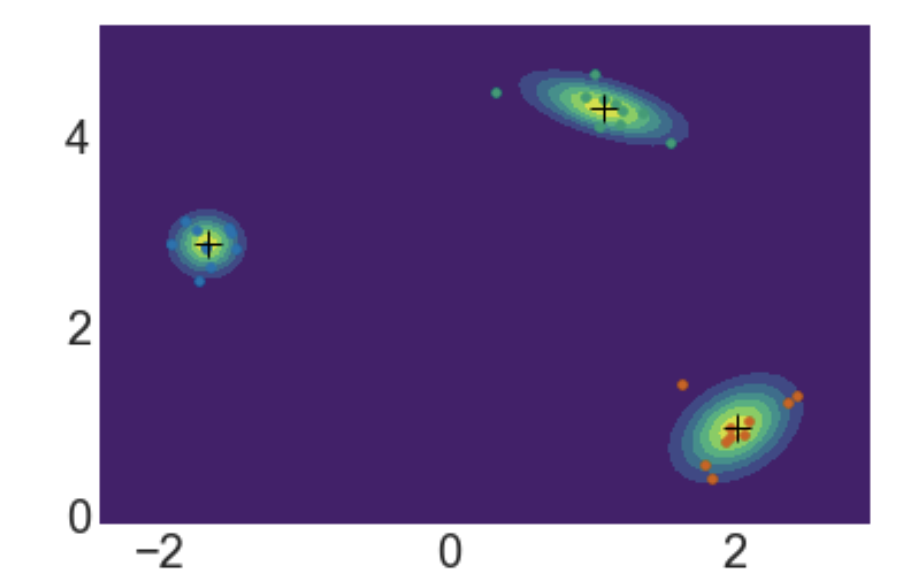

iteration: 3


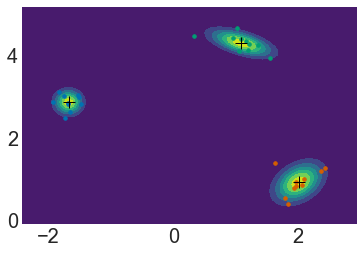

In [403]:
np.random.seed(0)

df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)

simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=True)
simple_test.plot_clusters(super_simple)

### 5c) EM algorithm animation visualization

- Add an optional parameter to `EM::cluster` called `animate`. By default, make it set to False.
- In the main EM loop, after performing a full iteration of EM, call the `plot_clusters` method (if `animate` is true). Immediately before your method call, add the code: `clear_output(wait=True)`. Immediately after, add the code: `plt.pause(0.1)` (The parameter, 0.1 in this case, is the wait time in seconds between plot updates in the animation).

Running this test code, should produce a (**very cool**) animation showing the EM algorithm unfolding over time. You should see if overcome a challenging initial condition.

Here is an image of what the final clustering should look like:

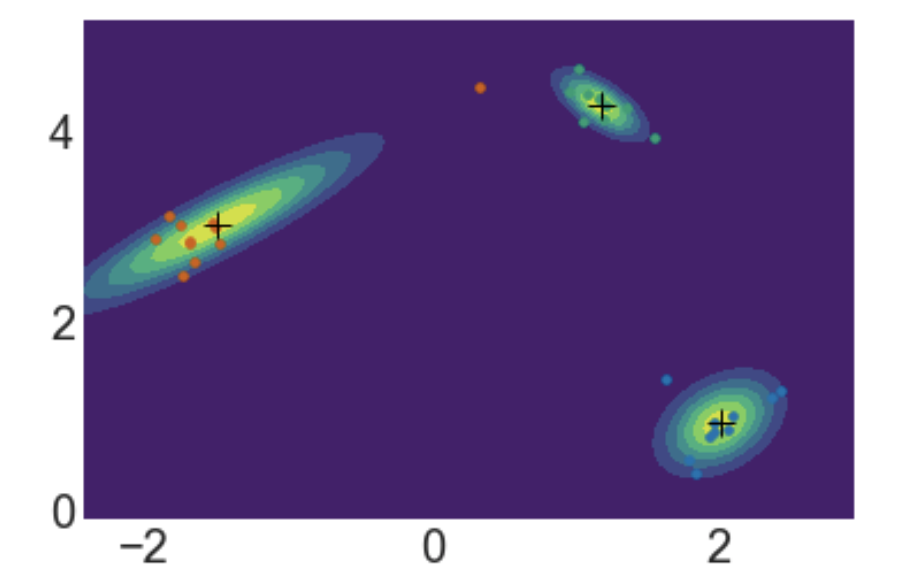

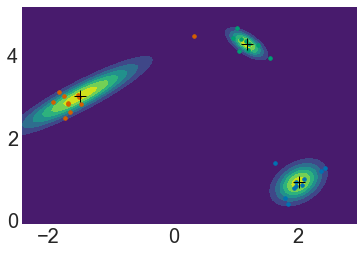

iteration: 25


In [404]:
np.random.seed(4)

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, animate=True);

### 5d) Outlier detection with EM algorithm

Because the EM algorithm computes the probability that each data sample belongs to each cluster, it can be used to detect outliers in the dataset.

- Implement `find_outliers` in `em.py`.
- Run the following code to find outliers in the `super_simple` dataset (defined as samples belonging to a cluster that have probability < 0.5 here).

In [405]:
# Find outliers in all 3 clusters
outliers = simple_test.find_outliers(thres=0.5)
print(f'Sample indices of your outliers are\n{outliers}\nand they should be\n[(array([20, 26]),), (array([], dtype=int64),), (array([ 0, 18, 28]),)]')

Sample indices of your outliers are
[array([20, 26]), array([], dtype=int64), array([ 0, 18, 28])]
and they should be
[(array([20, 26]),), (array([], dtype=int64),), (array([ 0, 18, 28]),)]


- In the cell below, superimpose a plot on the cluster plot, indicating the outliers that you found with star markers (make them large so that they stand out). It should look like the following image:

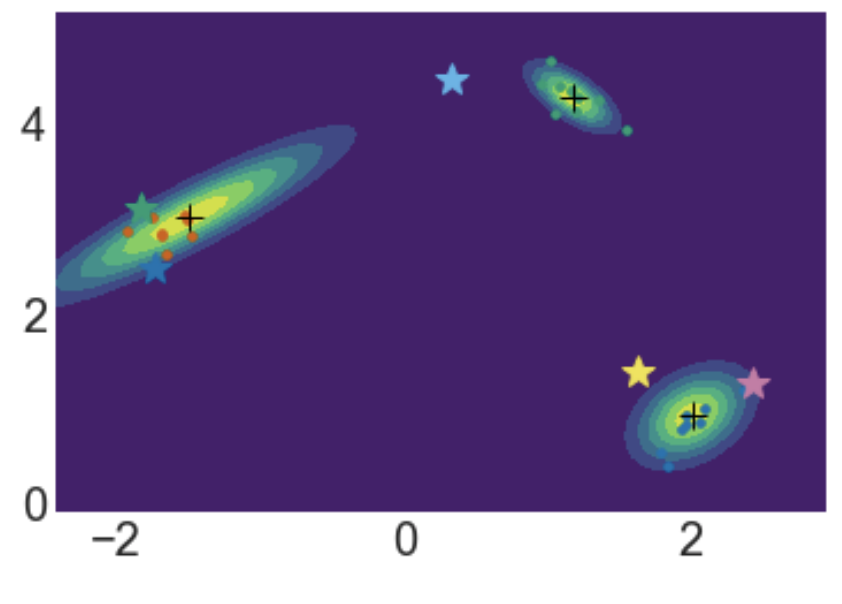

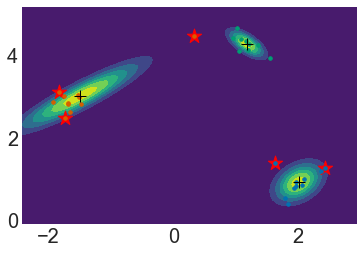

In [420]:
simple_test.plot_clusters(super_simple, show=False)

# Your code here
for i in range(simple_k):
    pts = super_simple[outliers[i],:]
    plt.scatter(pts[:,0], pts[:,1], marker = '*', s = 15**2, color = 'red')

## Task 6) Cluster a dataset of your choice with EM algorithm

- Select a 2D dataset (one we've worked with before or a new one of your choice).
    - You may select a higher dimensional dataset, but only run EM on 2 variables **that make sense (see next item)**
    - You may select a higher dimensional dataset and run PCA to reduce the dimensionality to 2D.
- Formulate a question (see question below) that could be addressed by cluster analysis.
- Import/preprocess to prepare the data for clustering by the EM algorithm.
- Analyze the data. Minimally, this should include:
    - Select a k that makes sense to you (you may explore this more rigorously as an extension).
    - Plot of the 2D data clustered.
    - Detect and show outliers
    - Report the final log likelihood of the clustering.

iteration: 22


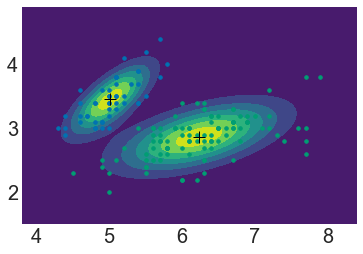

final log likelihood -225.9157337672239


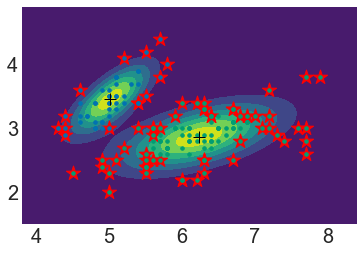

In [425]:
np.random.seed(0)

iris = pd.read_csv('data/iris.csv')

X = iris["sepalLength"]
Y = iris["sepalWidth"]
iris_data = np.zeros((iris.shape[0],2))
iris_data[:,0] = X
iris_data[:,1] = Y
# print(iris_data)

iris_k = 2
iris_max_iter = 100

iris_test = em.EM(iris_data)

iris_test.cluster(k=iris_k, max_iter=iris_max_iter, verbose=True)
iris_test.plot_clusters(iris_data)
print('final log likelihood', iris_test.loglikelihood_hist[-1])

# draw outliers
outliers = iris_test.find_outliers(thres=0.5)
iris_test.plot_clusters(iris_data, show=False)
for i in range(iris_k):
    pts = iris_data[outliers[i],:]
    plt.scatter(pts[:,0], pts[:,1], marker = '*', s = 15**2, color = 'red')

- I chose K to be 2 because the data samples appear to have 2 clusters
- The final log likelihood is -225.9157337672239, indicating the an "ok" fit bewteen the data and the cluster detected.

**Question 5:** What dataset did you select for clustering?

**Answer 5:** I used Iris dataset.

**Question 6:** Which two variables did you select for clustering? What question are you exploring, which you believe could be addressed by a cluster analysis?

**Answer 6:** I selected 'sepalLength' and 'sepalWidth'. I want to explore the idea of sub-category within Iris. I believe the cluster analysis could perfectly address this question. My assumption is that there might be several patterns of 'sepalLength' and 'sepalWidth' combinations; if my assumption/hypothesis were true, then there should be identifiable clusters that tell/represent the different types of combinations. Such combinations, then, may indicate that there exist sub-categories of Iris flower.

**Question 7:** What is your interpretation of what the outliers that you detected mean in the context of your dataset?

**Answer 7:** Outliers are data samples that could be seen as "exceptions" of the clusters detected. In this case, if my hypothesis is true--that Iris has 2 sub-categories--then there should be few outliers. However, there are quite a lot outliers in the graph as we can see. One interpretaion may be that there are actually dinstinctive sub-categories within Iris flowers. 

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Detect number of clusters in other datasets

- Cluster other datasets and create elbow plots and/or silhouette plots to detect the number of clusters.

### 2) Better initial conditions

- EM has the same centroid initialization problem as K-means. Implement a version of K-means++ initialization for EM. Analyze the differences vs. the random initialization scheme.

### 3) Image compression

- Run K-means on other images and quantify the reduction in space required to store each image (with different values of k).

### 4) Make an `elbow_plot` for EM algorithm

- Test out and explain results of your `elbow_plot` method on a dataset.

NOTE: Log likelihood is negative and higher is better. Factor this into your interpretation.

### Idea behind
- Instead of using "inertia", each simulation's final **log_likelihood** in EM algorithm could be used as a metric to tell how well the predictions are (since better convergence is when the the log_likelihood being close to the zero)

iteration: 2
iteration: 30
iteration: 64
iteration: 80
iteration: 85
iteration: 100


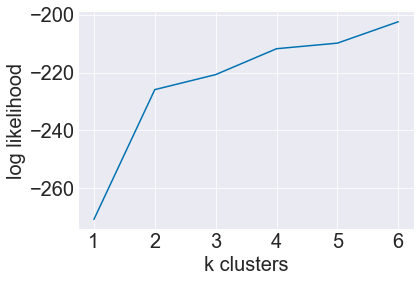

In [435]:
iris_test.elbow_plot(6)

### Analysis
- After k = 2, the change in log_likelihood is significantly smaller, and therefore we say k = 2 should be the ideal cluster number.

### 5) K-means vs. EM algorithm

- Compare the efficiency of K-means and EM. Create plots showing runtime, number of iterations, etc. Analyze / interpret the results.

### 6) Cluster additional datasets

## Acknowledgment

I worked with Jiyao Chen, Luhang Sun, Azalea Yunus, Cornelia Wang, and Chris Zhu to finish this project.